In [3]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
%matplotlib inline
from td_utils import *

In [ ]:
for file_name in os.listdir('./raw_data/background'):
    if file_name.lower().endswith('.wav'):
        file_path = os.path.join('./raw_data/background', file_name)
        audio = AudioSegment.from_file(file_path)

        # Check duration in milliseconds
        duration_ms = len(audio)
        
        # Check if duration is exactly 10000 ms (10 seconds)
        if duration_ms != 10000:
            print(f"Removing {file_name} with duration {duration_ms} ms")
            os.remove(file_path)

In [ ]:
IPython.display.Audio("./raw_data/alexa/1.wav")

In [ ]:
IPython.display.Audio("./raw_data/negative/academy.wav")

In [ ]:
IPython.display.Audio("./raw_data/background/1_0.wav")

In [3]:
# define the limitations of the data format
Tx = 5511 # The number of time steps input to the model (spectrogram)
n_freq = 101 # Number of frequencies input to the model at each time step (spectrogram)
Ty = 1375 # The number of time steps in the output
np.random.seed(42)

In [ ]:
# Load raw audio files and resample
def load_audio_files(path, target_rate=44100):
    alexa = []
    negative = []
    background = []

    for file in os.listdir(path + 'alexa'):
        if file.lower().endswith('wav'):
            alex = AudioSegment.from_wav(path + "alexa/" + file)
            alex = resample_audio(alex, target_rate)
            alexa.append(alex)
    for file in os.listdir(path + 'negative'):
        if file.lower().endswith('wav'):
            neg = AudioSegment.from_wav(path + "negative/" + file)
            neg = resample_audio(neg, target_rate)
            negative.append(neg)
    for file in os.listdir(path + 'background'):
        if file.lower().endswith('wav'):
            back = AudioSegment.from_wav(path + "background/" + file)
            back = resample_audio(back, target_rate)
            background.append(back)  
    
    return alexa, negative, background

def resample_audio(audio_segment, target_rate=44100):
    return audio_segment.set_frame_rate(target_rate)

In [ ]:
# Load audio segments using pydub 
#alexa, negative, background = load_raw_audio('./raw_data/')

alexa, negative, background = load_audio_files('./raw_data/', 44100)

print("background len is 10,000, since the background sounds are sliced to 10 seconds audios\n" + str(len(background[72])),"\n")
print("different `alexa` clips can have different lengths\n" + str(len(alexa[1])) + ' or ' + str(len(alexa[2])),"\n")
print("different `negative` clips can have different lengths as well \n" + str(len(negative[1])) + ' or ' + str(len(negative[5])),"\n")

In [ ]:
def get_random_time_segment(segment):
    
    #Gets a random time segment of duration segment_ms in an audio clip.
    segment_start = np.random.randint(low=0, high=10000-segment)
    segment_end = segment_start + segment - 1
    
    return (segment_start, segment_end)

In [ ]:
# example of the random segment where alexa[2] is inserted
random_segment = get_random_time_segment(len(alexa[2]))
print(random_segment)

In [ ]:
def is_overlap(segment_time, previous_segments):

    segment_start, segment_end = segment_time

    flag = False

    for prev_segment_start, prev_segment_end in previous_segments:
        if segment_start <= prev_segment_end and segment_end >= prev_segment_start:
            
            flag = True
            break
    return flag

In [ ]:
# example of the random segment in the list

random_segment = get_random_time_segment(len(alexa[2]))
random_segment_2 = [value+3000 for value in random_segment]
list_segment = []
list_segment.append(random_segment)

In [ ]:
random_segment

In [ ]:
random_segment_2

In [ ]:
is_overlap(random_segment_2, list_segment)

In [ ]:
def insert_audio_clip(background, audio_clip, previous_segments):
    
    segment_ms = len(audio_clip)
    segment_time = get_random_time_segment(segment_ms)
    
    retry = 5 
    while is_overlap(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1
        print(segment_time)

    if not is_overlap(segment_time, previous_segments):
        previous_segments.append(segment_time)
        new_background = background.overlay(audio_clip, position = segment_time[0])
    else:
        print('Timeout')
        new_background = background
        segment_time = (10000, 10000)
    
    return new_background, segment_time

In [ ]:
background_0 = background[0]
audio_0 = alexa[0]
previous_segments = [(3790, 4400)]

new_back, random_seg = insert_audio_clip(background_0, audio_0, previous_segments)

In [ ]:
new_back

In [ ]:
def insert_ones(y, audio_end):

    # number of time steps in the output
    _,Ty = y.shape

    # transform audio_end from ms to output time steps
    audio_end_y = int((audio_end * Ty)/10000)

    if audio_end_y < Ty:
        for i in range(50):
            if audio_end_y+i+1 < Ty:
                y[0][audio_end_y+i+1] = 1
            else:
                break
            
    return y
    

In [ ]:
y = np.zeros((1, Ty))
audio_end = 5530

insert_ones(y, audio_end)


In [ ]:
y[0][762]
print(y[0].shape)

In [ ]:
# check if exactly 50 ones added
counter = 0
for i in range(60):
    if y[0][760+i] == 1.0:
        counter += 1

print(counter)

In [2]:
import matplotlib.pyplot as plt
from scipy.io import wavfile

#####Helper functions from the project
# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200  # Length of each window segment
    fs = 8000  # Sampling frequencies
    noverlap = 120  # Overlap between windows
    nchannels = data.ndim

    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, NFFT=nfft, Fs=fs, noverlap=noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:, 0], NFFT=nfft, Fs=fs, noverlap=noverlap)
    # Print debug information
    print(f"rate: {rate}, data shape: {data.shape}")
    print(f"pxx shape: {pxx.shape}, freqs shape: {freqs.shape}, bins shape: {bins.shape}")
    
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def load_raw_audio(path):
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir(path + "activates"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav(path + "activates/" + filename)
            activates.append(activate)
    for filename in os.listdir(path + "backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav(path + "backgrounds/" + filename)
            backgrounds.append(background)
    for filename in os.listdir(path + "negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav(path + "negatives/" + filename)
            negatives.append(negative)
    return activates, negatives, backgrounds


def create_training_sample(single_background, alexa, negative, Ty):
    
    background = single_background - 20
    y = np.zeros((1,Ty))
    previous_segments = []


    num_alexa = random.randint(1,2)
    indices_alexa = np.random.randint(len(alexa), size=num_alexa)
    alexa_samples = [alexa[i] for i in indices_alexa]

    for alexa_sample in alexa_samples:
        background, alexa_sample_new = insert_audio_clip(background, alexa_sample, previous_segments)
        _, alexa_sample_new_end = alexa_sample_new
        insert_ones(y,alexa_sample_new_end)

    num_negative = random.randint(0,2)
    indices_negative = np.random.randint(len(negative), size=num_negative)
    negative_samples = [negative[i] for i in indices_negative]

    for negative_sample in negative_samples:
        background, _ = insert_audio_clip(background, negative_sample, previous_segments)

    print(len(background))
    background = match_target_amplitude(background, -20.0)
    
    file = background.export('train' + '.wav', format='wav')
    x = graph_spectrogram('train.wav')
    
    return x,y

In [ ]:
x, y = create_training_sample(background[2], alexa, negative, Ty)

In [ ]:
print(x.shape)
print(y.shape)

In [ ]:
graph_spectrogram('train.wav').shape

In [ ]:
IPython.display.Audio("train.wav")

In [ ]:
plt.plot(y[0])

In [ ]:
nsamples = 1000
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    a = random.randint(0, len(background)-1)
    background_current = background[a]
    create_training_sample(background_current, alexa, negative, Ty)
    X.append(x.swapaxes(0,1))
    print(x.shape)
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)

In [4]:
X= np.load(f'/media/data/uv/X.npy')
Y= np.load(f'Y.npy')

In [ ]:
x.shape

In [ ]:
#X_combined = np.concatenate((X, X_1), axis=0)
#Y_combined = np.concatenate((Y, Y_1), axis=0)

# Optionally, save the combined data
#np.save("./XY/X_combined.npy", X_combined)
#np.save("./XY/Y_combined.npy", Y_combined)

#print(f"Combined X shape: {X_combined.shape}")
#print(f"Combined Y shape: {Y_combined.shape}")

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, TimeDistributed, Conv1D
from tensorflow.keras.layers import GRU, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam

In [6]:
def modelf(input_shape):
    X_input = Input(shape = input_shape)

    X = Conv1D(filters = 512, kernel_size=15, strides=4)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3)(X)

    X = LSTM(units=256, return_sequences=True)(X)
    X = Dropout(rate=0.3)(X)
    X = BatchNormalization()(X)

    X = LSTM(units=128, return_sequences=True)(X)
    X = Dropout(rate=0.3)(X)
    X = BatchNormalization()(X)

    X = Dense(64, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(rate=0.3)(X)

    X = TimeDistributed(Dense(1, activation='sigmoid'))(X)

    model = Model(inputs=X_input, outputs=X)

    return model

In [7]:
model = modelf(input_shape = (Tx, n_freq))

2024-07-05 19:41:09.235190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:13:00.0, compute capability: 8.0


In [ ]:
model.summary()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC

opt = Adam(learning_rate=2e-5)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics = [AUC(name='auc')]
)

checkpoint_callback = ModelCheckpoint(
    filepath='model{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_freq='epoch',  
    verbose=1     
)

history = model.fit(
    X_train, y_train,
    epochs=30,    
    batch_size=10,
    callbacks=[checkpoint_callback]
)


In [ ]:
y_train.shape

In [ ]:
X_train.shape

In [ ]:
model.fit(X_train, y_train, 
          epochs=15, 
          batch_size=10)

In [ ]:
loss, auc = model.evaluate(X_test, y_test)
print("Test set precision = ", loss)
print("Test set recall = ", auc)

In [ ]:
model.save('./model')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model/model.keras')


In [ ]:
# test on newly generated test samples
# see function create_training_sample
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)
    audio_clip = resample_audio(audio_clip, target_rate=44100)
    file_handle = audio_clip.export("test_out.wav", format="wav")
    filename = "test_out.wav"

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

detect_triggerword('test.wav')

In [ ]:
IPython.display.Audio("test_out.wav")

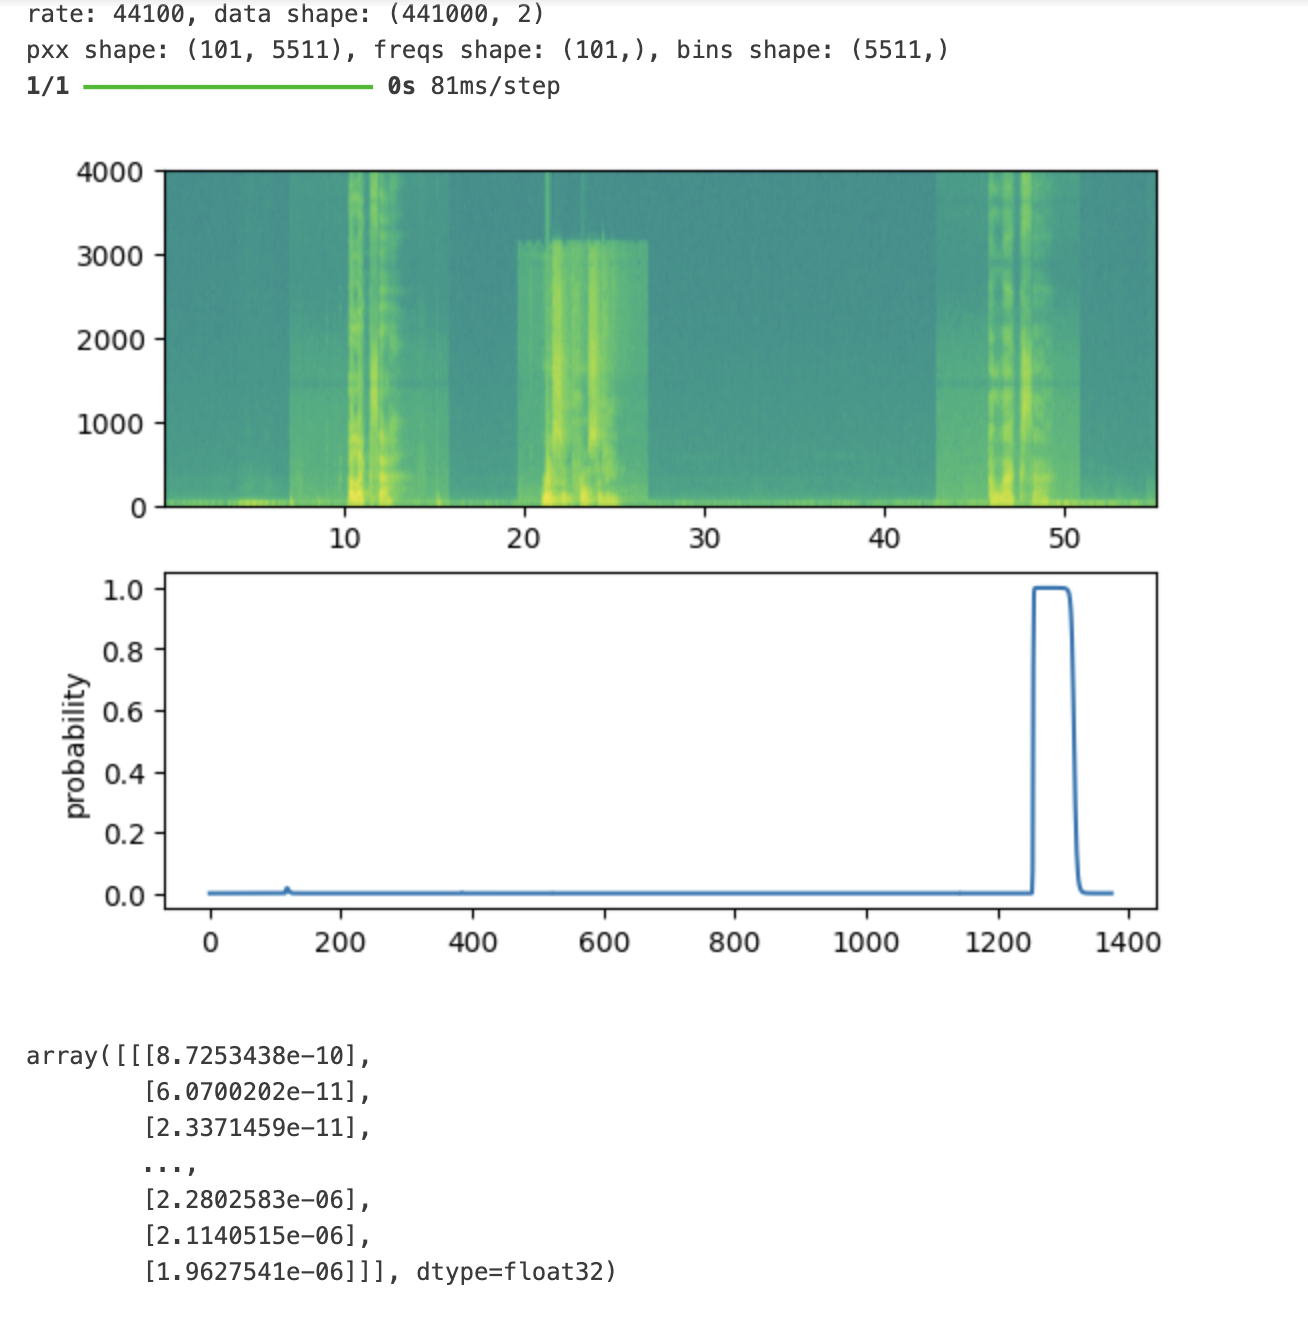

In [17]:
from IPython.display import Image, display
image_path = "probability.png"
display(Image(filename=image_path))